# Anomaly Detection using Isolation Forest

In [1]:
import sys, getopt, os, pickle
import pandas as pd
import numpy as np
import math
import optuna
# from notebooks.util.training import load_data, load_data_fraud, anomaly_scores, evaluate_results, evaluate_predictions
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


모든 모델에 대하여 자동으로 최적의 하이퍼 파라미터를 찾아주는 Optuna 라이브러리를 사용하여 파라미터를 튜닝할 것이다(반복수:100). cross-validation은 class imbalance를 고려하여 stratified k-fold로 진행하겠다. 

In [3]:
train = pd.read_csv('train_preprocessed.csv', index_col = 0)
train_y = train['target']
del train['target']

In [3]:
def objective_if(trial):
    # global X_train
    # global X_test
    
    params={
        
        'n_estimators' :trial.suggest_int('n_estimators', 20, 200),
        'max_samples' : trial.suggest_uniform('max_samples', 0.15, 0.65),
        'contamination' : trial.suggest_loguniform('contamination', 0.034, 0.075),
        'max_features' : trial.suggest_uniform('max_features', 0.3, 0.75),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]) }
    
    # 아래 잘못된 변수명 있으면 고치기 
    
    clf = IsolationForest(**params)
    clf.fit(X_train) 
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    y_pred_test = pd.DataFrame(y_pred_test)
    y_pred = []
    
    #Isolation Forest는 정상치를 1, 이상치를 -1로 출력하기 때문에 정상치를 0, 이상치를 1로 출력하도록 변환
    for i in range(len(y_pred_test)):
        if y_pred_test.iloc[i,0] == 1 :
            y_pred_test.iloc[i,0] = 0
        else:
            y_pred_test.iloc[i,0] = 1
        
    f1 = f1_score(y_test, y_pred_test,average='micro')
    
    return f1
    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2,stratify=train_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-23 05:04:03,543] A new study created in memory with name: no-name-a1598d8d-3284-45e0-ad50-a9cac661a292
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

F1-score에서 유의미한 증가가 발견되지 못해 iteration을 멈췄다. 

위 Optuna를 통해 선정된 F1-score를 최대화해주는 최적의 하이퍼 파라미터들을 사용하여 최종모델을 만들고 test 예측값 출력

Trial 10 finished with value: 0.9341414446880539 and parameters: {'n_estimators': 58, 'max_samples': 0.17935762807922848, 'contamination': 0.03407907267936104, 'max_features': 0.47850063376325724, 'bootstrap': True}

In [4]:
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2,stratify=train_y, random_state=1111)

In [7]:
clf = IsolationForest(n_estimators=58, max_samples=0.17935762807922848, contamination = 0.03407907267936104, max_features = 0.47850063376325724, bootstrap = True, random_state=1111)
clf.fit(X_train) 
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
    
y_pred_test = pd.DataFrame(y_pred_test)
y_pred = []
    
#Isolation Forest는 정상치를 1, 이상치를 -1로 출력하기 때문에 정상치를 0, 이상치를 1로 출력하도록 변환
for i in range(len(y_pred_test)):
    if y_pred_test.iloc[i,0] == 1 :
        y_pred_test.iloc[i,0] = 0
    else:
        y_pred_test.iloc[i,0] = 1
    
f1 = f1_score(y_test, y_pred_test,average='micro')
f1

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [8]:
f1

0.9335954235024319

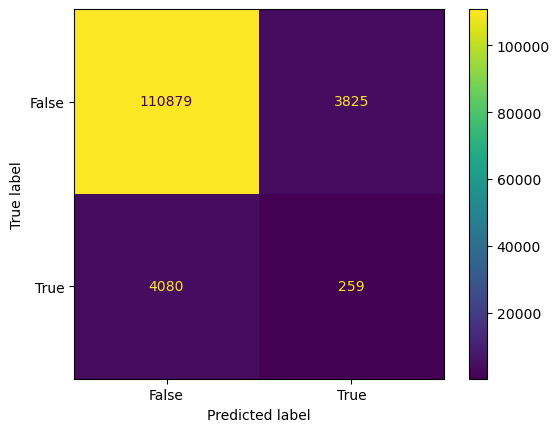

In [13]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

False : 정상치  
True : 이상치

실제로 이상치인 관측치가 4080개인데 예측을 이상치로 한게 259개 밖에 안됨.  
근데 이상치라고 예측한건 259+3825 = 4084개임.  
이상치가 아닌데 이상치로 분류한게 3825개나 되는건 심각한거 아닌가..?

In [10]:
import pickle

In [17]:
pickle.dump(clf, open('Anomaly Detection - Isolation Forest.sav', 'wb')) 
# loaded_model = pickle.load(open('Anomaly Detection - Isolation Forest.sav', 'rb'))

# 축소된 데이터를 이용하여 다시 모델링

In [2]:
train = pd.read_csv('train_reduced.csv', index_col = 0)
train_y = train['target']
del train['target']

test = pd.read_csv('test_reduced.csv', index_col = 0)
test_y = test['target']
del test['target']

In [4]:
X_train, X_test, y_train, y_test = train, test, train_y, test_y

In [5]:
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-28 16:13:40,930] A new study created in memory with name: no-name-f31e1c80-a9a6-4a82-8106-4c2fff4bd42a
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

Trial 98 finished with value: 0.9332213355732886 and parameters: {'n_estimators': 161, 'max_samples': 0.15041053295255394, 'contamination': 0.034013674754003465, 'max_features': 0.7196634355962549, 'bootstrap': False }

In [8]:
clf = IsolationForest(n_estimators=161, max_samples=0.15041053295255394, contamination = 0.034013674754003465, max_features = 0.7196634355962549, bootstrap = False, random_state=1111)
clf.fit(X_train) 
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
    
y_pred_test = pd.DataFrame(y_pred_test)
y_pred = []
    
#Isolation Forest는 정상치를 1, 이상치를 -1로 출력하기 때문에 정상치를 0, 이상치를 1로 출력하도록 변환
for i in range(len(y_pred_test)):
    if y_pred_test.iloc[i,0] == 1 :
        y_pred_test.iloc[i,0] = 0
    else:
        y_pred_test.iloc[i,0] = 1
    
f1 = f1_score(y_test, y_pred_test,average='micro')
f1

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


0.9302813943721125

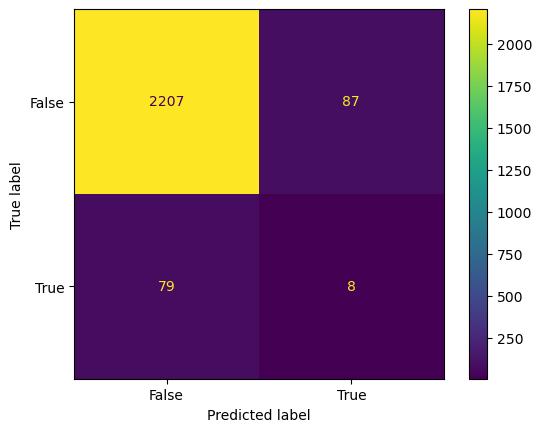

In [9]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


In [11]:
pickle.dump(clf, open('Anomaly Detection - Isolation Forest_reduced.sav', 'wb')) 
# loaded_model = pickle.load(open('Anomaly Detection - Isolation Forest_reduced.sav', 'rb'))